# K-means Clustering

In [1]:
# Import packages
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.io                            # Used to load the *.mat files
from random import sample                  # Used for random initialization
import matplotlib.cm as cm                 # Used to display images 
import imageio                             # Used to load images

## 1: Implementing K-means

### 1.1: Finding closest centroids

In [2]:
# Read in data.mat (use scipy.io
datafile = 'data/data.mat'
X = scipy.io.loadmat(datafile)['X']

In [3]:
# X is 300 points, each has two coordinates.
print(X.shape)

(300, 2)


In [4]:
# Choose the number of centroids K = 3
K = 3

# Choose the initial centroids
initial_centroids = np.array([[3,3],[6,2],[8,5]])

In [5]:
# Function for Visualizing the data
def plotData(myX, mycentroids, myidxs = None):
    
    colors = ['b','g','gold','darkorange','salmon','olivedrab']
    
    assert myX[0].shape == mycentroids[0][0].shape
    assert mycentroids[-1].shape[0] <= len(colors)

    if myidxs is not None:
        assert myidxs.shape[0] == myX.shape[0]
        subX = []
        for x in range(mycentroids[0].shape[0]):
            subX.append(np.array([myX[i] for i in range(myX.shape[0]) if myidxs[i] == x]))
    else:
        subX = [myX]
        
    fig = plt.figure(figsize=(7,5))
    for x in range(len(subX)):
        newX = subX[x]
        plt.plot(newX[:,0],newX[:,1],'o',color=colors[x],
                 alpha=0.75, label='Data Points: Cluster %d'%x)
    plt.xlabel('x1',fontsize=14)
    plt.ylabel('x2',fontsize=14)
    plt.title('Plot of X Points',fontsize=16)
    plt.grid(True)

    #Drawing a history of centroid movement
    tempx, tempy = [], []
    for mycentroid in mycentroids:
        tempx.append(mycentroid[:,0])
        tempy.append(mycentroid[:,1])
    
    for x in range(len(tempx[0])):
        plt.plot(tempx, tempy, 'rx--', markersize=8)

    leg = plt.legend(loc=4, framealpha=0.5)

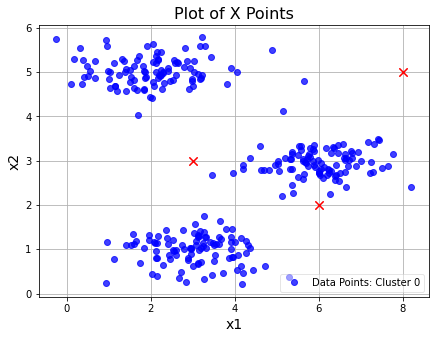

In [6]:
plotData(X, [initial_centroids])

In [7]:
# 计算两点之间距离的平方
def distSquared(point1, point2):
    return np.sum(np.square(point2-point1))

In [8]:
def findClosestCentroids(myX, mycentroids):
    """
    myX is a (m,n) matrix, where m is the # of points, n is # of features per point.
    mycentroids is a (K,n) centroid seed matrix, where K is the # of centroids (clusters).
    The function returns a (m,1) vector of cluster indices for each point in X (0 through K-1).
    """
    idxs = np.zeros((myX.shape[0],1))
    
    # Loop through each data point in X
    for x in range(idxs.shape[0]):
        # Return the index of the nearest centroid for each point
        dist2centroids = []
        for k in range(mycentroids.shape[0]):
            dist2centroids.append(distSquared(myX[x], mycentroids[k]))
        dist2centroids = np.array(dist2centroids)
        idxs[x] = dist2centroids.argmin()
        
    return idxs

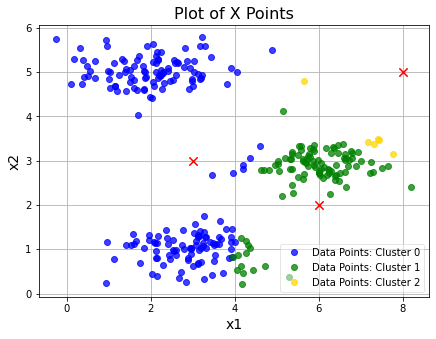

In [9]:
# Assign X to initial centroids
idxs = findClosestCentroids(X, initial_centroids)
plotData(X,[initial_centroids],idxs)

### 1.2: Computing centroid means

In [10]:
def computeCentroids(myX, myidxs, K):
    """
    myX is a (m,n) matrix, where m is the # of points, n is # of features per point.
    myidxs is a (m,1) matrix, represents the cluster indexes for each point.
    The function returns a new (K,n) centroid matrix which is the mean value of each cluster.
    """
    centroid = np.zeros((K, myX.shape[1]))
    for x in range(K):
        tmp = np.where(myidxs == x)[0]
        for i in range(tmp.size):
            centroid[x] += myX[tmp[i]]
        centroid[x] /= tmp.size
    return centroid

## 2: K-means on example dataset

In [11]:
def runKMeans(myX, initial_centroids, K, n_iter):
    """
    Function that actually does the iterations.
    """
    centroid_history = []
    current_centroids = initial_centroids
    for myiter in range(n_iter):
        centroid_history.append(current_centroids) # Save the history of current centroids
        idxs = findClosestCentroids(myX, current_centroids) # Update the nearest centroids for each point
        current_centroids = computeCentroids(myX, idxs, K=K) # Update the centroids
        
    return idxs, centroid_history

In [12]:
# Run KMeans with K = 3, n_iter = 10
idxs, centroid_history = runKMeans(X, initial_centroids, K, n_iter=10)

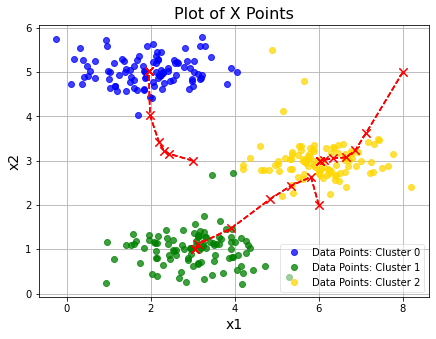

In [13]:
plotData(X, centroid_history, idxs)

## 3: Random initialization

In [14]:
# Randomly sample K initial centroids
def chooseKRandomCentroids(myX, K):
    rand_indices = sample(range(0,myX.shape[0]),K)
    return np.array([myX[i] for i in rand_indices])

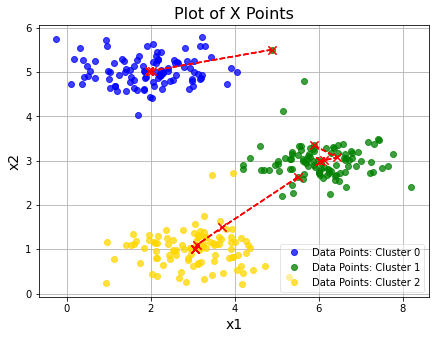

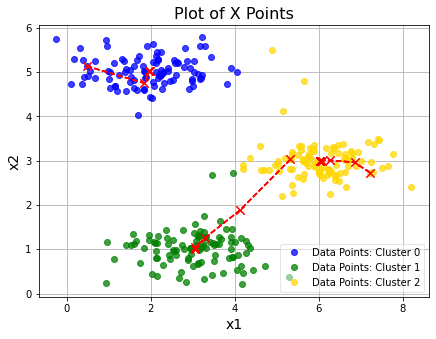

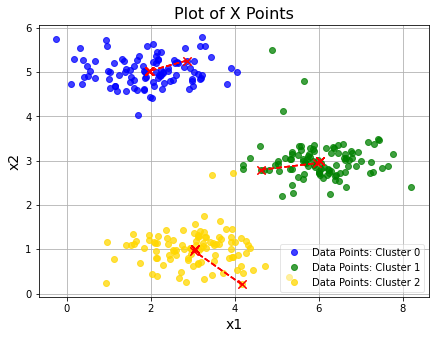

In [15]:
# Let's choose 3 set of random initial centroids and see the resulting 
for x in range(3):
    idxs, centroid_history = runKMeans(X, chooseKRandomCentroids(X, 3),
                                       K=3, n_iter=10)
    plotData(X, centroid_history, idxs)

## 4: Image compression with K-means

### 4.1: K-means on pixels

In [16]:
# It reads a three-dimensional matrix A whose first two indices are pixel positions and last index represents red, green, or blue.
datafile = 'data/bird_small.png'
A = imageio.imread(datafile)
print("A shape is ",A.shape)

A shape is  (128, 128, 3)


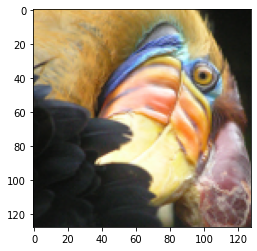

In [17]:
dummy = plt.imshow(A)

In [18]:
# Divide every entry in A by 255 so all values are in the range of 0 to 1
A = A/255.

# Unroll the image to shape (16384,3) (16384 is 128*128)
A = A.reshape(-1, 3)

# Run k-means on this data, forming 16 clusters, with random initialization
myK = 16
idxs, centroid_history = runKMeans(A, chooseKRandomCentroids(A, myK), K=myK, n_iter=10) # Use runKMeans

In [19]:
# Now I have 16 centroids, each representing a color.
# Let's assign an index to each pixel in the original image dictating which of the 16 colors it should be.
# Loop through the original image and form a new image that only has 16 colors in it (Let the color of each pixel be the color of its centroids).
final_centroids = centroid_history[-1]
final_image = np.zeros((128 ** 2, 3)) # Initialize with zeros
for x in range(final_image.shape[0]):
    final_image[x] = final_centroids[int(idxs[x])]

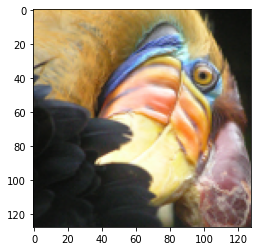

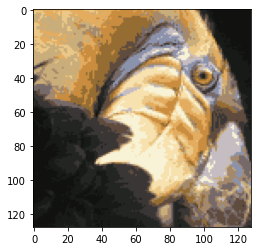

In [20]:
# plot and compare the compressed image with the original one
plt.figure()
dummy = plt.imshow(A.reshape(128,128,3))
plt.figure()
dummy = plt.imshow(final_image.reshape(128,128,3))